In [1]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import time

import warnings
warnings.filterwarnings("ignore")

n_fft = 1024
hop_length = 8
sr = 16000

# cate bucati PF iau in considerare pentru AF -> cu overlapping => 15 frame-uri 
# ultimul frame din AF fiind PF-ul curent
nb_of_frames_in_AF = 4
# exp_w_avg_beta = 0.98
marja_eroare = 1e-2

# frame_length_ms = 5
# total_length_ms = 5000.0
# nb_of_samples = 80000
samples_per_frame_10ms = 160 #(int)(160000 * 10 / 10000.0)
samples_per_frame_5ms = 80 #(int)(80000 * 5 / 5000.0)

In [2]:
def normaliz(mix):
    mu = np.mean(mix, axis=0)
    var = np.var(mix, axis=0)

    mix_norm = (mix - mu) / np.sqrt(var + 1e-8)
    
    return mix_norm

In [3]:
def compute_mask(stft_1, stft_2):
    # small epsilon to avoid dividing by zero
    eps = np.finfo(np.float).eps

    # compute model as the sum of spectrograms
    mix = eps + np.abs(stft_1) + np.abs(stft_2)    
    mask = np.divide(np.abs(stft_1), mix)
    
    return mask

In [4]:
def get_STFT_AF_frames(AF_array, PF_size):
    frames = []
    half = (int)(PF_size/2)
    frames_added = 0
    
    i = AF_array.shape[0]-1
    
    # use AF as 4 times bigger than PF's size -> PF = 10 ms => AF = 40 ms
    
    #---------------------------------------------------------------------------
    # 1. add PF[i]
    frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 2. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 3. add PF[i - 1]
    frame = librosa.stft(librosa.to_mono(AF_array[i - 1]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 4. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
        
    
    return np.asarray(frames)

In [5]:
def get_train_set_for_mix(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < 2:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - 2, index)])      
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))
    return np.array(inputs), np.array(targets)
    

In [25]:
class Network(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 10 ms
    # 5 ms  = [513, 11]
    def __init__(self, height = 513, width = 21):
        super(Network, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.fc1 = nn.Linear(1 * height * width, 300)
        self.fc_batch = nn.BatchNorm1d(300)
        
        # layer 2
        self.fc2 = nn.Linear(300, 300)
        
        # layer 3
        self.fc3 = nn.Linear(300, height * width)
        self.fc3_batch = nn.BatchNorm1d(height * width)

    def forward(self, x):
        
        # layer 1
        # firstly, transform the matrix into an array for the FC
        x = x.view(-1, self.height * self.width)        
        x = self.fc1(x)
        x = self.fc_batch(x)
        x = torch.relu(x)
#         x = self.drop(x)
        
        # layer 2
        x = self.fc2(x)
        x = self.fc_batch(x)
        x = torch.relu(x)
#         x = self.drop(x)
        
#          # layer 2
#         x = self.fc2(x)
#         x = self.fc_batch(x)
#         x = torch.relu(x)
# #         x = self.drop(x)
        
#                  # layer 2
#         x = self.fc2(x)
#         x = self.fc_batch(x)
#         x = torch.relu(x)
# #         x = self.drop(x)
        
        # layer 3
        x = self.fc3(x)
        x = self.fc3_batch(x)
        x = torch.relu(x)
        
        x = x.view(nb_of_frames_in_AF, self.height, self.width) 
        
        return x

In [7]:
class NetworkConv(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 10 ms
    # 5 ms  = [513, 11]
    def __init__(self, height = 513, width = 21):
        super(NetworkConv, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, padding=2)
        self.conv1_batch = nn.BatchNorm2d(20)
        self.max_pool = nn.MaxPool2d(kernel_size=2, padding=1)
        
        # layer 2
        self.conv2 = nn.Conv2d(20, 20, kernel_size=5, padding=2)
        self.conv2_batch = nn.BatchNorm2d(20)
    
        # layer 3
        self.fc1 = nn.Linear(20 * 129 * 6, 400)
        self.fc1_batch = nn.BatchNorm1d(400)
        
        # layer 4
        self.fc2 = nn.Linear(400, 400)
        
        # layer 5
        self.fc3 = nn.Linear(400, height * width)
        self.fc3_batch = nn.BatchNorm1d(height * width)

    def forward(self, x):
        
        # firstly, transform the matrix into an array for the FC
        
        
        # layer 1
        x = self.conv1(x)
        x = self.conv1_batch(x)
        x = torch.relu(x)
        
        # layer 2
        x = self.conv2(x)
        x = self.conv2_batch(x)
        x = torch.relu(x)
        
        # layer 3
        x = x.view(-1, self.height * self.width * 20) 
        x = self.fc1(x)
        x = self.fc1_batch(x)
        x = torch.relu(x)
        
        # layer 4
        x = self.fc2(x)
        x = self.fc2_batch(x)
        x = torch.relu(x)
        
        x = x.view(nb_of_frames_in_AF, self.height, self.width) 
        
        return x

In [8]:
loss_function = nn.MSELoss()

In [9]:
def make_mix_of_10_seconds(voice):
    nb_sample_for_10_seconds = 160000
    
    if len(voice) < nb_sample_for_10_seconds:
        voice = np.pad(voice, (0,(nb_sample_for_10_seconds - len(voice) )), 'constant', constant_values=(0))
    elif len(voice) > nb_sample_for_10_seconds:
        voice = voice[0:nb_sample_for_10_seconds]
    
    return voice        

In [10]:
def make_mix_of_5_seconds(voice):
    nb_sample_for_5_seconds = 80000
    
    if len(voice) < nb_sample_for_5_seconds:
        voice = np.pad(voice, (0,(nb_sample_for_5_seconds - len(voice) )), 'constant', constant_values=(0))
    elif len(voice) > nb_sample_for_5_seconds:
        voice = voice[0:nb_sample_for_5_seconds]
    
    return voice   

In [11]:
def get_voice_interchanged(voice, is_valid):
    voices = []
    pos_half = (int)(len(voice) / 2)
    pos_1quart = (int)(pos_half / 2)
    pos_3quart = (int)(pos_half + (pos_half / 2))
    pos_1third = 26000
    
    if is_valid == True:
        voice_perm = voice[pos_1third * 2 :len(voice)]
        voice_perm = np.append(voice_perm, voice[0:pos_1third])
        voice_perm = np.append(voice_perm, voice[pos_1third:pos_1third * 2])
        voices.append(voice_perm)
    else:
        voices.append(voice)

        voice_perm = voice[pos_3quart:len(voice)]
        voice_perm = np.append(voice_perm, voice[0:pos_1quart])
        voice_perm = np.append(voice_perm, voice[pos_1quart:pos_half])
        voice_perm = np.append(voice_perm, voice[pos_half:pos_3quart])
        voices.append(voice_perm)
        
        voice_perm = voice[pos_half:pos_3quart]
        voice_perm = np.append(voice_perm, voice[pos_3quart:len(voice)])
        voice_perm = np.append(voice_perm, voice[pos_1quart:pos_half])
        voice_perm = np.append(voice_perm, voice[0:pos_1quart])
        voices.append(voice_perm)
        
        voice_perm = voice[pos_1quart:pos_half]
        voice_perm = np.append(voice_perm, voice[pos_half:pos_3quart])
        voice_perm = np.append(voice_perm, voice[pos_3quart:len(voice)])
        voice_perm = np.append(voice_perm, voice[0:pos_1quart])
        voices.append(voice_perm)
        
        voice_perm = voice[pos_3quart:len(voice)]
        voice_perm = np.append(voice_perm, voice[0:pos_1quart])
        voice_perm = np.append(voice_perm, voice[pos_half:pos_3quart])
        voice_perm = np.append(voice_perm, voice[pos_1quart:pos_half])
        voices.append(voice_perm)


        voice_perm = voice[pos_1quart:pos_half]
        voice_perm = np.append(voice_perm, voice[pos_half:len(voice)])
        voice_perm = np.append(voice_perm, voice[0:pos_1quart])
        voices.append(voice_perm)
    
    return np.array(voices)
    
    # split voice into smaller batches/chunks
    # np.array_split takes as args the data input and the number of batches!!! not the number of elems in a batch
#     if is_valid == False:
#         voice_batches = np.array_split(np.array(voice),5)
#     else:
#         voice_batches = np.array_split(np.array(voice),6)
        
#     np.random.shuffle(voice_batches)

#     voice_perm = []
#     for v in voice_batches:
#         voice_perm.extend(v)
    
#     return np.array(voice_perm)

In [12]:
def create_set_from_voices(voice1_file_name, voice2_file_name, 
                                 samples_per_frame, mix_5_seconds):
    inputs_list = []
    targets_list = []
    
            
    voice1, sr = librosa.load(voice1_file_name, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_file_name, sr=16000)
    voice2 = np.append(voice2, voice2)

    # pad smaller array with zeros if it's the case or delete last entries
    if mix_5_seconds == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)

    # load the mixed audio 
    mix = voice1 + voice2

    voice1 = np.array(voice1)
    voice2 = np.array(voice2)
    mix = np.array(mix)

    inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
    inputs_list.extend(inputs)
    targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("create_set_from_voices dims: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [13]:
def create_interchanged_set_from_voices(voice1_file_name, voice2_file_name, 
                                 samples_per_frame, mix_5_seconds, nb_of_permutations, is_validation):
    inputs_list = []
    targets_list = []
    
    noise_filename = 'recordings/noises/piano5sec.wav'
    
    voice1, sr = librosa.load(voice1_file_name, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_file_name, sr=16000)
    voice2 = np.append(voice2, voice2)
    
    noise, sr = librosa.load(noise_filename, sr=16000)
    noise = np.append(noise, noise)

    # pad smaller array with zeros if it's the case or delete last entries
    if mix_5_seconds == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
        noise = make_mix_of_5_seconds(noise)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)
        noise = make_mix_of_10_seconds(noise)

    voices1 = get_voice_interchanged(voice1, is_validation)
    voices2 = get_voice_interchanged(voice2, is_validation)
        
    for i in range(len(voices1)):
            mix = voices1[i] + voices2[i]
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voices1[i], voices2[i], samples_per_frame)
            print(inputs.shape)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    # add combinations : voice1+noise and voice2+noise only for TRAIN SET
#     if is_validation == False:
#         noise = noise / 5
#         mix = voice1 + noise
#         mix = np.array(mix)

#         inputs, targets = get_train_set_for_mix(mix, voice1, noise, samples_per_frame)
#         print(inputs.shape)
#         inputs_list.extend(inputs)
#         targets_list.extend(targets)

#         mix = voice2 + noise
#         mix = np.array(mix)

#         inputs, targets = get_train_set_for_mix(mix, voice2, noise, samples_per_frame)
#         print(inputs.shape)
#         inputs_list.extend(inputs)
#         targets_list.extend(targets)
    #------------------------------------------------------------
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("create_interchanged_set_from_voices dims: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [14]:
def create_set_with_noise_from_voices(voice1_file_name, voice2_file_name, 
                                            samples_per_frame, mix_5_seconds, noise_filename):
    inputs_list = []
    targets_list = []
    
            
    voice1, sr = librosa.load(voice1_file_name, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_file_name, sr=16000)
    voice2 = np.append(voice2, voice2)

    noise, sr = librosa.load(noise_filename, sr=16000) 
    noise = np.append(noise, noise)
    noise = noise / 5

    # pad smaller array with zeros if it's the case or delete last entries
    if mix_5_seconds == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
        noise = make_mix_of_5_seconds(noise)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)
        noise = make_mix_of_10_seconds(noise)

    # load the mixed audio 
    mix = voice1 + voice2 + noise

    voice1 = np.array(voice1)
    voice2 = np.array(voice2)
    noise = np.array(noise)
    mix = np.array(mix)

    inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
    inputs_list.extend(inputs)
    targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("create_set_with_noise_from_voices dims: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [15]:
def create_set_from_voices_80_10_10(voice1_file_name, voice2_file_name, 
                                          samples_per_frame, mix_5_seconds):
            
    voice1, sr = librosa.load(voice1_file_name, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_file_name, sr=16000) 
    voice2 = np.append(voice2, voice2)

    # pad smaller array with zeros if it's the case or delete last entries
    if mix_5_seconds == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)

    train_len = (int)(80/100 * len(voice1))
    diff = (int)( (len(voice1) - train_len) / 2)
    
    # --------------------------------------split voices into train/valid/test sets
    voice1_train = voice1[:train_len]
    voice2_train = voice2[:train_len]
    print(len(voice1_train))
    
    voice1_valid = voice1[train_len:(train_len + diff)]
    voice2_valid = voice2[train_len:(train_len + diff)]
    print(len(voice1_valid))
    
    voice1_test = voice1[(train_len + diff):len(voice1)]
    voice2_test = voice2[(train_len + diff):len(voice2)]
    print(len(voice1_test))

    voice1 = np.array(voice1)
    voice2 = np.array(voice2)

    # -------------------------------------compute train set [with permutations or without]
    inputs_list, targets_list = [], []
        
#     mix = voice1_train + voice2_train
#     mix = np.array(mix)

#     inputs, targets = get_train_set_for_mix(mix, voice1_train, voice2_train, samples_per_frame)
#     inputs_list.extend(inputs)
#     targets_list.extend(targets)
    
            
    voices1 = get_voice_interchanged(voice1_train, False)
    voices2 = get_voice_interchanged(voice2_train, False)
        
    for i in range(len(voices1)):
            mix = voices1[i] + voices2[i]
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voices1[i], voices2[i], samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)

#   for i in range(nb_of_permutations):

#       voice1_perm = get_voice_interchanged(voice1_train)
#       voice2_perm = get_voice_interchanged(voice2_train)

#       mix = voice1_perm + voice2_perm
#       mix = np.array(mix)

#       inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
#       inputs_list.extend(inputs)
#       targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    train_set = dict(zip(inputs_list, targets_list))
    
    # ------------------------------------------------------compute valid set
    inputs_list, targets_list = [], []
    
    mix = voice1_valid + voice2_valid
    inputs, targets = get_train_set_for_mix(mix, voice1_valid, voice2_valid, samples_per_frame)
    inputs_list.extend(inputs)
    targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    valid_set = dict(zip(inputs_list, targets_list))

    # ---------------------------------------------------------compute test set
    inputs_list, targets_list = [], []
    
    mix = voice1_test + voice2_test
    inputs, targets = get_train_set_for_mix(mix, voice1_test, voice2_test, samples_per_frame)
    inputs_list.extend(inputs)
    targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    test_set = dict(zip(inputs_list, targets_list))
    
    print("create_set_from_voices_80_10_10 sets dim:", len(train_set), len(valid_set), len(test_set))
    return train_set, valid_set, test_set

In [16]:
noise_filename = 'recordings/noises/piano5sec.wav'
noise2_filename = 'recordings/noises/engine.wav'
noise3_filename = 'recordings/noises/beeps.wav'

voice1_file_name = 'recordings/voice1/arctic_a0007.wav'
voice2_file_name = 'recordings/voice2/arctic_a0032.wav'

voice1_file_names_list2 = ['recordings/voice1/arctic_a0407.wav']
voice2_file_names_list2 = ['recordings/voice2/arctic_a0032.wav']

noises_list = ['recordings/noises/engine.wav', 'recordings/noises/applauses.wav', 'recordings/noises/beeps.wav']


train_set_80, valid_set_10, test_set_10 = create_set_from_voices_80_10_10(voice1_file_name, voice2_file_name,
                                                                        samples_per_frame=samples_per_frame_10ms,
                                                                        mix_5_seconds=True)
# un singur mix, intreg, simplu
train_set = create_set_from_voices(voice1_file_name, voice2_file_name, 
                                         samples_per_frame = samples_per_frame_10ms,
                                        mix_5_seconds= True)

# un singur mix, intreg, 3 inregistrari, din care 2 permutate
train_set_interchanged = create_interchanged_set_from_voices(voice1_file_name, voice2_file_name, 
                                         samples_per_frame = samples_per_frame_10ms,
                                        mix_5_seconds= True, nb_of_permutations = 3, is_validation=False)

# un singur mix, intreg, permutat in alt mod fata de permutarile din train
# are si un noise de applause in functie, doar trebuie comentat / decomentat cand e adaugat in mix
valid_set = create_interchanged_set_from_voices(voice1_file_name, voice2_file_name,
                                                    samples_per_frame = samples_per_frame_10ms,
                                                    mix_5_seconds= True, nb_of_permutations = 1, is_validation=True)

# un singur mix, intreg, contine doar cele doua voci pentru care s-a facut trainul
test_set = create_set_from_voices(voice1_file_name, voice2_file_name,
                                                    samples_per_frame=samples_per_frame_10ms,
                                                    mix_5_seconds= True)

# un singur mix, intreg, cele doua voci + zgomot de pian
test_set_with_noise = create_set_with_noise_from_voices(voice1_file_name, voice2_file_name,
                                                    samples_per_frame=samples_per_frame_10ms,
                                                    mix_5_seconds= True, 
                                                    noise_filename=noise_filename)

64000
8000
8000
create_set_from_voices_80_10_10 sets dim: 2388 48 48
create_set_from_voices dims:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
(498, 4, 1, 513, 21)
(498, 4, 1, 513, 21)
(498, 4, 1, 513, 21)
(498, 4, 1, 513, 21)
(498, 4, 1, 513, 21)
(498, 4, 1, 513, 21)
create_interchanged_set_from_voices dims:  torch.Size([2988, 4, 1, 513, 21]) torch.Size([2988, 513, 21])
(498, 4, 1, 513, 21)
create_interchanged_set_from_voices dims:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
create_set_from_voices dims:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
create_set_with_noise_from_voices dims:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])


In [17]:
def train_network(nr_epochs, train_set, valid_set, test_set, model_name, optimizer, network):

    # plot train/valid loss contains losses on each epoch, so we can see after each epoch what happens with the error
    plot_train_losses = []
    plot_valid_losses = []
    plot_train_accuracy = []
    plot_valid_accuracy = []


    epoch = 1
    while epoch <= nr_epochs:
        
        correct_train = 0
        correct_test = 0
        train_losses, valid_losses = [], []
        loss = 0

        # training part 
        network.train()
        for index, (input, target) in enumerate(train_set.items()):

            # if cuda is available, send (input, target) to gpu
            input, target = input.cuda(), target.cuda()

            optimizer.zero_grad()

            # 1. forward propagation
            output = network(input)


            # 2. loss calculation
            loss = loss_function(target, output[len(output)-1])  


            # 3. backward propagation
            loss.backward() 


            # 4. weight optimization
            optimizer.step()


            # 5. save the loss for this PF
            train_losses.append(loss.item())

            
            # 6. check how many items where predicted correctly
            correct_train += 1 if loss.item() <= marja_eroare else 0 
            

        # add the mean loss for this training epoch for ploting
        train_mean_loss_for_epoch = np.mean(train_losses)
        plot_train_losses.append(train_mean_loss_for_epoch)
        
        current_accuracy = (int)(100. * correct_train / len(train_set))
        plot_train_accuracy.append(current_accuracy)

        if epoch % 10 == 0 or epoch == 1:
            print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
            print("Train set -> ", "loss: ", loss.item(), "accuracy: ", current_accuracy, "%", "[" +
                  str(correct_train) + "/" + str(len(train_set)) + "]")
        
        #-----------------------------------------------------------------------
        # evaluation part 
#         network.eval()
        if epoch % 1 == 0:
#             
            with torch.no_grad():
                for index, (input, target) in enumerate(valid_set.items()):

                    # if cuda is available, send (input, target) to gpu
                    input, target = input.cuda(), target.cuda()

                    # 1. forward propagation
                    output = network.forward(input)

                    # 2. loss calculation
                    loss = loss_function(target, output[len(output)-1]).detach().item()
                    
                    # 3. save loss for current PF
                    valid_losses.append(loss)

                    # 4. check how many items where predicted correctly
                    correct_test += 1 if loss <= marja_eroare else 0

                 # add the mean loss for this training epoch for ploting
                valid_mean_loss_for_epoch = np.mean(valid_losses)
                plot_valid_losses.append(valid_mean_loss_for_epoch)
                
                current_accuracy = (int)(100. * correct_test / len(valid_set))

                if epoch % 10 == 0 or epoch == 1 :
                    print("Valid set -> ", "loss: ", loss, "accuracy: ", current_accuracy, "%", "[" +
                          str(correct_test) + "/" + str(len(valid_set)) + "]")
                
                if len(plot_valid_accuracy) >= 1:
                    if current_accuracy > max(plot_valid_accuracy):
                        print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
                        torch.save(network, str(current_accuracy) + "-valid-"+ model_name)
                        network_test = torch.load(str(current_accuracy) + "-valid-" + model_name)
                        eval(network=network_test, test_set=test_set)
            
            plot_valid_accuracy.append(current_accuracy)
            
            if len(plot_valid_losses) >= 5:
                valid_l = plot_valid_losses[len(plot_valid_losses) - 5 : len(plot_valid_losses)]
                train_l = plot_train_losses[len(plot_train_losses) - 5 : len(plot_train_losses)]
                if valid_l == sorted(valid_l) and train_l == sorted(train_l, reverse=True):
                    
                    print("Stop training due to validation loss increasing [training loss decreasing] for 5 consecutive epochs.")
                    break
                if all(x >= 98 for x in plot_valid_accuracy[len(plot_valid_accuracy) - 10: len(plot_valid_accuracy)]):
                    print("Stop training due to validation accuracy greater than 98% for 10 epochs.")
                    break
                    
        epoch += 1

    torch.save(network, model_name)
    
    plt.plot(plot_train_losses, label='Training loss')
    plt.plot(plot_valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    plt.plot(plot_train_accuracy, label='Training accuracy')
    plt.plot(plot_valid_accuracy, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()

In [18]:
# RECONSTRUIRE SUNET PE FRAME-URI, FOLOSIND TARGETURILE GENERATE PT SETUL DE ANTRENARE
def split_audios_epoch(name, mask, mix, samples_per_frame):
    
    frame_pos = (int)(nb_of_frames_in_AF/2)

    mask_stack = torch.stack(mask)
    cpu_mask = mask_stack.cpu()
    n_mask = cpu_mask.detach().numpy()

    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    sound1 = np.empty([0,])
    sound2 = np.empty([0,])


    for i in range (0, len(mix_frames)):
        stft_mix = librosa.stft(librosa.to_mono(mix_frames[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
        
        # reteaua nu a invatat mastile pentru primele frame_pos bucati [PF] din mix
        # deci las matricea STFT asa cum e in mix
        if i < frame_pos :
            y_frame_1_stft_with_mask = stft_mix
            y_frame_2_stft_with_mask = stft_mix

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))
            
        else:
            # n_mask[i-7] pentru ca reteaua invata pt AF-uri facute pe cate 8 PF-uri -> 15 items pt AF
            # abia de cand ajunge la primul AF care s a putut compune, folosesc masca invata de retea
            
            y_frame_1_stft_with_mask = np.multiply(n_mask[i-frame_pos], stft_mix)
            y_frame_2_stft_with_mask = np.multiply((1 -  n_mask[i-frame_pos]), stft_mix)

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))


    librosa.output.write_wav("recordings/voice1-"+ str(name) + ".wav", sound1, sr = 16000)
    librosa.output.write_wav("recordings/voice2-"+ str(name) + ".wav", sound2, sr = 16000)

In [19]:
def eval(network, test_set):

#     network.eval()
                
    test_loss, test_mask, test_accuracy = [], [], []
    correct_test = 0

    with torch.no_grad():
        for index, (input, target) in enumerate(test_set.items()):

            # if cuda is available, send (input, target) to gpu
            input, target = input.cuda(), target.cuda()

            # 1. forward propagation
            output = network.forward(input)

            # 2. loss calculation
            loss = loss_function(target, output[len(output)-1]).detach().item()

            # 3. save the mask for the current PF, meaning the last entry in the output
            current_mask = output[len(output)-1]
            test_mask.append(current_mask)

            test_loss.append(loss)

            # 4. check how many items where predicted correctly
            correct_test += 1 if loss <= marja_eroare else 0


        current_accuracy = 100. * correct_test / len(test_set)
        print("Test set -> ", "test loss: ", np.mean(test_loss), "accuracy: ", (int)(current_accuracy), "%", "[" +
                          str(correct_test) + "/" + str(len(test_set)) + "]")

        return test_mask

In [20]:
def runAdam(nr_epochs, train_set, valid_set, test_set, mixnb):

    print("__________________________________________ADAM FC_________________________________")
    torch.cuda.empty_cache()
    
    model_name = str(nr_epochs) + "epoci-"+ mixnb + ".pth"
    
    network = Network()
    
    print("network sent to CUDA")
    network.cuda()
    
    # set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
    optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))
        
    start_time = time.time()
    train_network(nr_epochs=nr_epochs, 
                train_set=train_set, valid_set=valid_set, test_set = test_set,
                model_name=model_name,
                optimizer=optimizer,
                network=network)
    
    elapsed_time = time.time() - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed time for " + model_name + " : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    return model_name
    

In [21]:
def runAdamConv(nr_epochs, train_set, valid_set, test_set, mixnb):
    
    print("__________________________________________ADAM CONV + FC_________________________________")
    torch.cuda.empty_cache()
    
    model_name = str(nr_epochs) + "epoci-"+ mixnb + ".pth"
    
    networkConv = NetworkConv()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("networkConv sent to CUDA")
        networkConv.cuda()
        
    # set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
    optimizer = optim.Adam(networkConv.parameters(), lr = 0.001, betas = (0.9, 0.999))
    
    start_time = time.time()
    train_network(nr_epochs=nr_epochs, 
                train_set=train_set, valid_set=valid_set, test_set=test_set,
                model_name=model_name,
                optimizer=optimizer,
                network=networkConv)
    elapsed_time = time.time() - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed time for " + model_name + " : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    return model_name

In [22]:
def get_mix_from_voices(voice1_filename, voice2_filename, mix_5_sec):
    
    voice1, sr = librosa.load(voice1_filename, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_filename, sr=16000)
    voice2 = np.append(voice2, voice2)
    
    if mix_5_sec == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)
        
    mix = voice1 + voice2
    
    librosa.output.write_wav("recordings/mix-withOUT-noise.wav", mix, 16000)
    
    return mix

In [23]:
def get_mix_from_voices_with_noise(voice1_filename, voice2_filename, noise_filename, mix_5_sec):
    
    voice1, sr = librosa.load(voice1_filename, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_filename, sr=16000)
    voice2 = np.append(voice2, voice2)
    
    noise, sr = librosa.load(noise_filename, sr=16000)
    noise = np.append(noise, noise)
    noise = noise / 5
    
    if mix_5_sec == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
        noise = make_mix_of_5_seconds(noise)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)
        noise = make_mix_of_10_seconds(noise)
    
    mix = voice1 + voice2 + noise
    
    librosa.output.write_wav("recordings/mix-with-noise.wav", mix, 16000)
    return mix

__________________________________________ADAM FC_________________________________
network sent to CUDA
--------------------------------------Epoch 1 ------------------------------
Train set ->  loss:  0.11829706281423569 accuracy:  0 % [10/2988]
Valid set ->  loss:  0.11680864542722702 accuracy:  0 % [1/498]
--------------------------------------Epoch 2 ------------------------------
Test set ->  test loss:  0.09541109730732668 accuracy:  0 % [1/498]
--------------------------------------Epoch 4 ------------------------------
Test set ->  test loss:  0.08017326193935534 accuracy:  0 % [4/498]
--------------------------------------Epoch 5 ------------------------------
Test set ->  test loss:  0.0726564155880317 accuracy:  1 % [6/498]
--------------------------------------Epoch 7 ------------------------------
Test set ->  test loss:  0.06581813788479082 accuracy:  1 % [9/498]
--------------------------------------Epoch 8 ------------------------------
Test set ->  test loss:  0.063752

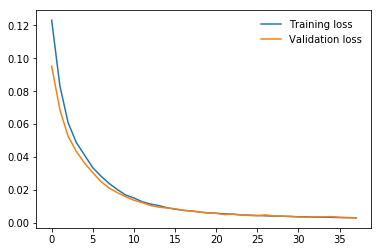

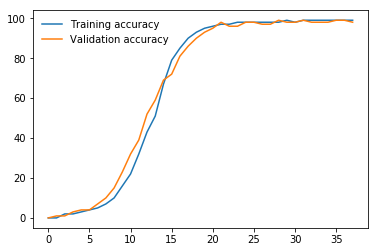

Elapsed time for 200epoci-FC-mix-intreg-permutat-v1(7)-v2(32).pth : 00:24:13.65
Test set ->  test loss:  0.0030180932380058935 accuracy:  98 % [493/498]
Test set ->  test loss:  0.05884460239469197 accuracy:  30 % [152/498]


In [26]:
import winsound
import os

voice1 = 'recordings/voice1/arctic_a0007.wav'
voice2 = 'recordings/voice2/arctic_a0032.wav'
    

# torch.cuda.empty_cache()
# model_name = runAdam(300, train_set, valid_set, test_set_with_noise, "FC-mix-intreg-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2, mix_5_sec=True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("FC-mix-intreg-v1(7)-v2(32)-test", test_mask, mix, samples_per_frame=samples_per_frame_10ms)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav', mix_5_sec = True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("FC-mix-intreg-v1(7)-v2(32)-test-noise", test_mask, mix, samples_per_frame=samples_per_frame_10ms)
#-----------------------------------------------------------------------------------

# torch.cuda.empty_cache()
# model_name = runAdamConv(200, train_set, valid_set, test_set_with_noise, "CONV-mix-intreg-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("CONV-mix-intreg-v1(7)-v2(32)-test", test_mask, mix)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav')
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("CONV-mix-intreg-v1(7)-v2(32)-test-noise", test_mask, mix)

#-----------------------------------------------------------------------------------


# torch.cuda.empty_cache()
# model_name = runAdam(200, train_set_80, valid_set_10, test_set_10, "FC-mix-80-10-10-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2, mix_5_sec=True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("FC-mix-80-10-10-v1(7)-v2(32)-test", test_mask, mix, samples_per_frame_10ms)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav', mix_5_sec=True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("FC-mix-80-10-10-v1(7)-v2(32)-test-noise", test_mask, mix, samples_per_frame_10ms)

# #-----------------------------------------------------------------------------------

# torch.cuda.empty_cache()
# model_name = runAdamConv(200, train_set_80, valid_set_10, test_set_10, "CONV-mix-80-10-10-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("CONV-mix-80-10-10-v1(7)-v2(32)-test", test_mask, mix)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav')
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("CONV-mix-80-10-10-v1(7)-v2(32)-test-noise", test_mask, mix)

# #-----------------------------------------------------------------------------------

torch.cuda.empty_cache()
model_name = runAdam(200, train_set_interchanged, valid_set, test_set_with_noise, "FC-mix-intreg-permutat-v1(7)-v2(32)")

# test first what it learned from train
mix = get_mix_from_voices(voice1, voice2, mix_5_sec=True)
network = torch.load(model_name)
test_mask = eval(network=network, test_set=test_set)
split_audios_epoch("FC-mix-intreg-permutat-v1(7)-v2(32)-test", test_mask, mix, samples_per_frame=samples_per_frame_10ms)

# test with noise
mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav', mix_5_sec = True)
network = torch.load(model_name)
test_mask = eval(network=network, test_set=test_set_with_noise)
split_audios_epoch("FC-mix-intreg-permutat-v1(7)-v2(32)-test-noise", test_mask, mix, samples_per_frame=samples_per_frame_10ms)


#------------------------------------------------------------------------------------------------
# mai trebuie convolutionala aici
# ------------------------------------------------------------------------------------
# torch.cuda.empty_cache()
# model_name = runAdam(200, train_set_interchanged_and_noisy, valid_set, test_set_with_noise, "FC-mix-intreg-permutat-si2zgomote-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2, mix_5_sec=True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("FC-mix-intreg-permutat-si2zgomote-v1(7)-v2(32)-test", test_mask, mix, samples_per_frame=samples_per_frame_10ms)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav', mix_5_sec = True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("FC-mix-intreg-permutat-si2zgomote-v1(7)-v2(32)-test-noise", test_mask, mix, samples_per_frame=samples_per_frame_10ms)

# ---------------------------------------------------------------------------------------------

# torch.cuda.empty_cache()
# model_name = runAdam(200, train_set_80, valid_set_10, test_set_10, "FC-mix-80-10-10-permutat-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2, mix_5_sec=True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("FC-mix-80-10-10-permutat-v1(7)-v2(32)-test", test_mask, mix, samples_per_frame_10ms)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav', mix_5_sec=True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("FC-mix-80-10-10-permutat-v1(7)-v2(32)-test-noise", test_mask, mix, samples_per_frame_10ms)

duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)
